In [2]:
import traceviz.client
import numpy as np
from traceviz.proto import  viz_pb2
import json

In [3]:
# ---
from bayes3d._mkl.utils import keysplit
import os
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import jit, vmap
import jax.numpy as jnp

key = jax.random.PRNGKey(0)

GenJAX not installed. Importing bayes3d without genjax dependencies.


In [10]:
msg = viz_pb2.Message()
msg.pytree.MergeFrom(traceviz.client.to_pytree_msg({"type": "setup",}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))



msg = viz_pb2.Message()
msg.pytree.MergeFrom(traceviz.client.to_pytree_msg({
        "type": "TEST",
        "data": np.ones((10,10)),
    }))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

response:  listener_identifiers: "2023-12-10T21:51:33.662632 :: ipv4:127.0.0.1:58408"

response:  listener_identifiers: "2023-12-10T21:51:33.662632 :: ipv4:127.0.0.1:58408"



## Spheres

In [4]:
t = 100
n = 100
key, keys = keysplit(key, 1, 3)
x0 = jax.random.normal(keys[0], (1,n,3))
xs = x0 + jnp.cumsum(0.03*jax.random.uniform(keys[0], (t,n,3)), axis=0)
cs = jnp.tile( jax.random.uniform(keys[1], (n,4)), (t,1,1))
ss = 0.1*jnp.tile( jax.random.uniform(keys[2], (n,4)), (t,1,1))

xs.shape, cs.shape

((100, 100, 3), (100, 100, 4))

In [4]:
msg = viz_pb2.Message()
msg.pytree.MergeFrom(traceviz.client.to_pytree_msg({"type": "setup",}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "animated spheres"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'centers': np.array(xs), 
        'colors':  np.array(cs),
        'scales':  np.array(ss)
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

response:  listener_identifiers: "2023-12-06T16:13:27.457570 :: ipv4:127.0.0.1:46164"

response:  listener_identifiers: "2023-12-06T16:13:27.457570 :: ipv4:127.0.0.1:46164"



## I Phone video data

In [5]:
import bayes3d
r3d_path = "data/2023-09-05--16-08-21.r3d.zip"
colors, depths, poses, intrinsics = bayes3d.utils.load_r3d(r3d_path)

Archive:  /tmp/2023-09-05--16-08-21.r3d.zip.zip
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/sound.m4a  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/72.depth  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/63.jpg  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/37.depth  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/299.depth  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/189.jpg  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/124.conf  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/77.jpg  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/431.conf  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/165.depth  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/120.depth  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/93.conf  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/348.conf  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/549.depth  
  inflating: /tmp/2023-09-05--16-08-21.r3d.zip/rgbd/198.depth  
  inflating:

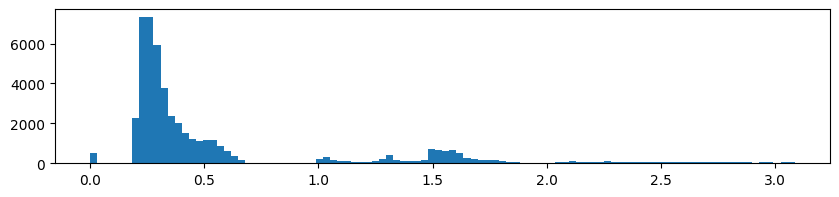

In [ ]:
depths.shape
t=0

plt.figure(figsize=(10,2))
plt.hist(depths[t].flatten(), bins=100);

In [ ]:
import bayes3d
from bayes3d.transforms_3d import unproject_depth, apply_transform
from bayes3d.utils import resize


In [ ]:
xs = np.array([unproject_depth(depths[i], intrinsics) for i in range(len(colors))])
ss = np.ones(xs.shape[:3] + (1,))

xs = np.array(vmap(apply_transform)(xs, poses))
xs[:, :, :, 1] *= -1

In [ ]:
cs = np.array([resize(colors[i], int(intrinsics.height), int(intrinsics.width)) for i in range(len(colors))])
cs = np.concatenate([cs/255, 1.*np.ones((*cs.shape[:3], 1))], axis=-1)

In [ ]:
T = xs.shape[0]
N = xs.shape[1]*xs.shape[2] 
T, N, xs.shape, cs.shape, poses.shape

(555, 49152, (555, 256, 192, 3), (555, 256, 192, 4), (555, 4, 4))

In [ ]:
from scipy.spatial.transform import Rotation as Rot

A = Rot.from_euler('xyz', [0,0, 0], degrees=True).as_matrix()

In [ ]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

In [58]:
k = -1
# for t in np.arange(T, step=40):
for t in [0]:
    msg = viz_pb2.Message()
    msg.payload.json = json.dumps({"type": "spheres"})
    msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
            'centers': np.array(xs).reshape(T,N,3)[t,:k]@A.T, 
            'colors':  np.array(cs).reshape(T,N,4)[t,:k], 
            'scales':  0.0025*np.array(ss).reshape(T,N,1)[t,:k], 
    }))
    stub = traceviz.client.connect()
    print('response: ', stub.Broadcast(msg))

response:  listener_identifiers: "2023-12-06T17:25:10.458558 :: ipv4:127.0.0.1:51232"

response:  listener_identifiers: "2023-12-06T17:25:10.458558 :: ipv4:127.0.0.1:51232"



In [23]:
# np.array(xs).reshape(T,N,3)[t,:k]
xs.shape

(555, 256, 192, 3)

In [50]:
from sklearn.mixture import GaussianMixture
from bayes3d._mkl.trimesh_to_gaussians import get_mean_colors, pack_transform, ellipsoid_embedding


key = keysplit(key)

# GMM config
# ----------
t = 0
key = keysplit(key)
n_components = 500
noise        = 0.0; 
X            = xs[t].reshape(-1,3)
X = X + np.random.randn(*X.shape)*noise
means_init   = X[np.random.choice(len(X), n_components, replace=False)]


# Fit the GMM
# -----------
gm = GaussianMixture(n_components=n_components, 
                     tol=1e-3, max_iter=100, 
                     covariance_type="full", 
                     means_init=means_init).fit(X)


In [55]:
ws = gm.weights_
mus        = gm.means_
covs       = gm.covariances_
labels     = gm.predict(X)
choleskys  = vmap(ellipsoid_embedding)(covs)
transforms = vmap(pack_transform, (0,0,None))(mus, choleskys, 2.0)
mean_colors, nums = get_mean_colors(np.array(cs[t]).reshape(-1,4), gm.n_components, labels)
valid = nums > 0
valid.sum()
transforms.shape, mean_colors.shape, valid.shape

((500, 4, 4), (500, 4), (500,))

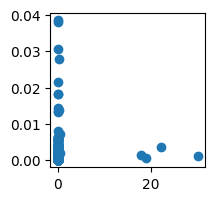

In [75]:
ms = jnp.max(jnp.linalg.norm(choleskys, axis=1), axis=-1) 

plt.figure(figsize=(2,2))
plt.scatter(ms, ws)

In [73]:
# sub  = ms < 0.3
sub = nums > 0

msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "gaussians"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'transforms': np.array(transforms )[sub][None], 
        'colors':     np.array(mean_colors)[sub][None]  
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  listener_identifiers: "2023-12-06T17:31:05.377225 :: ipv4:127.0.0.1:38842"

response:  listener_identifiers: "2023-12-06T17:31:05.377225 :: ipv4:127.0.0.1:38842"



In [60]:
k = -1
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "animated spheres"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'centers': np.array(xs).reshape(T,N,3)[:50,:k]@A.T, 
        'colors':  np.array(cs).reshape(T,N,4)[:50,:k], 
        'scales':  0.002*np.array(ss).reshape(T,N,1)[:50,:k], 
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

response:  listener_identifiers: "2023-11-30T17:52:55.215489 :: ipv4:127.0.0.1:58340"



response:  listener_identifiers: "2023-11-30T17:52:55.215489 :: ipv4:127.0.0.1:58340"



## IPhone 2

In [174]:
import bayes3d


data = np.load("data/ramen.npz")
depths = data["depths"]
colors= data["colors"]

intrinsics = bayes3d.Intrinsics(*data["intrinsics"])

xs = np.array([bayes3d.transforms_3d.unproject_depth(depths[i], intrinsics) for i in range(len(colors))])
cs = np.array([bayes3d.utils.resize(colors[i], int(intrinsics.height), int(intrinsics.width)) for i in range(len(colors))])
cs = np.concatenate([cs, np.ones((*cs.shape[:3], 1))], axis=-1)/255
ss = np.ones(xs.shape[:3] + (1,))

xs[:, :, :, 1] *= -1

T = xs.shape[0]
N = xs.shape[1]*xs.shape[2] 
T, N, depths.shape, colors.shape, xs.shape, cs.shape

(56,
 49152,
 (56, 256, 192),
 (56, 960, 720, 3),
 (56, 256, 192, 3),
 (56, 256, 192, 4))

In [181]:
from scipy.spatial.transform import Rotation as Rot

A = Rot.from_euler('xyz', [45, 0, 0], degrees=True).as_matrix()

In [180]:
k = -1
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "spheres"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'centers': xs.reshape(T,N,3)[0,:k]@A.T, 
        'colors':  cs.reshape(T,N,4)[0,:k], 
        'scales':  0.002*ss.reshape(T,N,1)[0,:k], 
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

response:  listener_identifiers: "2023-11-30T17:10:59.188165 :: ipv4:127.0.0.1:36214"

response:  listener_identifiers: "2023-11-30T17:10:59.188165 :: ipv4:127.0.0.1:36214"



In [182]:
k = -1
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "animated spheres"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'centers': xs.reshape(T,N,3)[:,:k]@A.T, 
        'colors':  cs.reshape(T,N,4)[:,:k], 
        'scales':  0.002*ss.reshape(T,N,1)[:,:k], 
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

response:  listener_identifiers: "2023-11-30T17:13:19.552283 :: ipv4:127.0.0.1:43880"

response:  listener_identifiers: "2023-11-30T17:13:19.552283 :: ipv4:127.0.0.1:43880"



In [ ]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
    "test": "I am a test string"
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "animated gaussians"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'transforms': np.array(transforms[:]), 
        'colors':  np.array(cs[:])
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

In [53]:
from bayes3d._mkl.trimesh_to_gaussians import pack_transform, ellipsoid_embedding

t = 100
n = 100
key, keys = keysplit(key, 1, 3)
x0 = jax.random.normal(keys[0], (1,n,3))
xs = x0 + jnp.cumsum(0.03*jax.random.uniform(keys[0], (t,n,3)), axis=0)
cs = jnp.tile( jax.random.uniform(keys[1], (n,4)), (t,1,1))
ss = 0.1*jnp.tile( jax.random.uniform(keys[2], (n,4)), (t,1,1))


choleskys = jax.random.normal(key, (n,3,3))
choleskys = jnp.tile(choleskys, (t,1,1,1))
transforms = vmap(pack_transform, (0,0,None))(xs.reshape(-1,3), choleskys.reshape(-1,3,3), 0.26)
transforms = transforms.reshape(t,n,4,4)
transforms.shape, choleskys.shape

((100, 100, 4, 4), (100, 100, 3, 3))

In [58]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
    "test": "I am a test string"
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "animated gaussians"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'transforms': np.array(transforms[:]), 
        'colors':  np.array(cs[:])
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

ValueError: Unhandled pytree input type: <class 'str'>. Value:
I am a test string